In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from superres import superres_metrics, ssim, psnr
from superres import RRDB_Net, MultiImageToMultiChannel, TwoXModel, TwoYLoss, MultiToMultiImageList, TransformableLists
import czifile
from superres.helpers import get_czi_shape_info, build_index
import imageio
import adabound

datasetname = 'multiframe_002'
data_path = Path('/scratch/bpho')
datasets = data_path/'datasets'
datasources = data_path/'datasources'
dataset = datasets/datasetname

hr_path = dataset/'hr'
lr_path = dataset/'lr'
lr_up_path = dataset/'lr_up'

In [2]:
from numbers import Integral

class MultiImage(ItemBase):
    def __init__(self, img_list):
        self.img_list = img_list

    def __repr__(self):
        return f'MultiImage: {[str(img) for img in self.img_list]}'

    @property
    def size(self):
        return [img.size for img in self.img_list]
    
    @property
    def data(self):
        img_data = torch.stack([img.data for img in self.img_list])
        num_img, c, h, w = img_data.shape
        data = tensor(img_data.view(num_img*c, h, w))
        return data

    def apply_tfms(self, tfms, **kwargs):
        first_time = True

        save_img_list = []
        for img in self.img_list:
            new_img = img.apply_tfms(tfms, do_resolve=first_time, **kwargs)
            first_time = False
            save_img_list.append(new_img)
        self.img_list = save_img_list
        return self
    
    def _repr_png_(self): return self._repr_image_format('png')
    def _repr_jpeg_(self): return self._repr_image_format('jpeg')

    def _repr_image_format(self, format_str):
        #return self.img_lists[0]._repr_image_format(format_str)
        with BytesIO() as str_buffer:
            img_data = np.concatenate([image2np(img.px) for img in self.img_list], axis=1)
            plt.imsave(str_buffer, img_data, format=format_str)
            return str_buffer.getvalue()

    def show(self, **kwargs):
        self.img_list[0].show(**kwargs)


        
        
        
def multi_normalize(x:TensorImage, mean:FloatTensor,std:FloatTensor)->TensorImage:
    "Normalize `x` with `mean` and `std`."
    return (x - mean) / std


def multi_denormalize(x:TensorImage, mean:FloatTensor,std:FloatTensor, do_x:bool=True)->TensorImage:
    "Denormalize `x` with `mean` and `std`."
    return x.cpu().float()*std + mean if do_x else x.cpu()

def _multi_normalize_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor, do_x:bool=True, do_y:bool=False)->Tuple[Tensor,Tensor]:
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
    x,y = b
    mean,std = mean.to(x.device),std.to(x.device)
    if do_x: x = multi_normalize(x,mean,std)
    if do_y and len(y.shape) == 4: y = multi_normalize(y,mean,std)
    return x,y

def multi_normalize_funcs(mean:FloatTensor, std:FloatTensor, do_x:bool=True, do_y:bool=False)->Tuple[Callable,Callable]:
    "Create normalize/denormalize func using `mean` and `std`, can specify `do_y` and `device`."
    mean,std = tensor(mean),tensor(std)
    return (partial(_multi_normalize_batch, mean=mean, std=std, do_x=do_x, do_y=do_y),
            partial(multi_denormalize, mean=mean, std=std, do_x=do_x))
        
def multi_image_channel_view(x):
    n_chan = 1
    return x.transpose(0,1).contiguous().view(n_chan,-1)

    

class MultiImageDataBunch(ImageDataBunch):
    def batch_stats(self, funcs:Collection[Callable]=None, ds_type:DatasetType=DatasetType.Train)->Tensor:
        "Grab a batch of data and call reduction function `func` per channel"
        funcs = ifnone(funcs, [torch.mean,torch.std])
        x = self.one_batch(ds_type=ds_type, denorm=False)[0].cpu()
        
        return [func(multi_image_channel_view(x), 1) for func in funcs]

    def normalize(self, stats:Collection[Tensor]=None, do_x:bool=True, do_y:bool=False)->None:
        "Add normalize transform using `stats` (defaults to `DataBunch.batch_stats`)"
        if getattr(self,'norm',False): raise Exception('Can not call normalize twice')
        if stats is None: self.stats = self.batch_stats()
        else:             self.stats = stats
        self.norm,self.denorm = multi_normalize_funcs(*self.stats, do_x=do_x, do_y=do_y)
        self.add_tfm(self.norm)
        
        return self



class MultiImageList(ImageList):
    "`ItemList` suitable for computer vision."
    _bunch,_square_show,_square_show_res = MultiImageDataBunch,True,True
    def __init__(self, *args,  **kwargs):
        super().__init__(*args, **kwargs)
        self.channels = 1
        
    def open(self, fn):
        img_data = np.load(fn)
        
        img_list = []
        if len(img_data.shape) == 4:
            for j in range(img_data.shape[0]):
                for i in range(img_data.shape[1]):
                    img_list.append(Image(tensor(img_data[j,i][None])))
        else:
            for i in range(img_data.shape[0]):
                img_list.append(Image(tensor(img_data[i][None])))
        
        self.channels = img_list[0].data.shape[0]
        return MultiImage(img_list)
        
    def reconstruct(self, t:Tensor):
        #set_trace()
        n, h, w = t.shape
        n //= self.channels
        one_img = t.view(self.channels,n*h,w)
        return Image(one_img.float().clamp(min=0,max=1))

class NpyRawImageList(ImageList):
    def open(self, fn):
        img_data = np.load(fn)
        return Image(tensor(img_data[None]))

    def analyze_pred(self, pred):
        return pred[0:1]

    def reconstruct(self, t):
        return Image(t.float().clamp(min=0,max=1))                

class MultiImageImageList(MultiImageList):
    _label_cls,_square_show,_square_show_res = NpyRawImageList,False,False

    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys`(targets)  on a figure of `figsize`."
        axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize)
        for i, (x,y) in enumerate(zip(xs,ys)):
            x.show(ax=axs[i,0], **kwargs)
            y.show(ax=axs[i,1], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        title = 'Input / Prediction / Target'
        axs = subplots(len(xs), 3, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
        for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
            x.show(ax=axs[i,0], **kwargs)
            y.show(ax=axs[i,2], **kwargs)
            z.show(ax=axs[i,1], **kwargs)

In [3]:
def map_to_hr(x):
    hr_name = x.relative_to(lr_up_path)
    return hr_path/hr_name

def get_src(size=128, scale=1):
    if scale != 1: use_lr_path = lr_path
    else: use_lr_path = lr_up_path
        
    def map_to_hr(x):
        hr_name = x.relative_to(use_lr_path)
        return hr_path/hr_name
    
    src = (MultiImageImageList
            .from_folder(lr_up_path, extensions=['.npy'])
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src

def get_data(bs, size, scale=1, max_zoom=1.):
    src = get_src(size, scale=scale)    
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    #tfms = [[],[]]
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size*scale)
            .databunch(bs=bs))#.normalize(do_y=True)
    return data

In [4]:
torch.cuda.device_count()

2

In [5]:
class TwoXModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        num_img = x.shape[1] // 2
        x1, x2 = x[:,0:num_img], x[:,num_img:]
        y1 = self.model(x1)
        y2 = self.model(x2)
        return torch.cat((y1,y2),1)
    
    
class TwoYLoss(nn.Module):
    def __init__(self, base_loss=F.mse_loss, stable_wt=0.15):
        super().__init__()
        self.base_loss = base_loss
        self.stable_wt = stable_wt
        self.base_loss_wt = (1-stable_wt)/2
        self.metric_names = ['pixel','stable','ssim','psnr']

    def forward(self, input, target):
        base_loss = self.base_loss
        y1 = input[:,0:1,:,:]
        y2 = input[:,1:2,:,:]
        base_1 = base_loss(y1, target)
        base_2 = base_loss(y2, target)
        stable_err = F.mse_loss(y1,y2)
        loss = (base_1 * self.base_loss_wt +
                base_2 * self.base_loss_wt +
                stable_err * self.stable_wt)
        self.metrics = {
            'pixel': (base_1+base_2)/2,
            'stable': stable_err,
            'ssim': (ssim.ssim(y1, target)+ssim.ssim(y2,target))/2,
            'psnr': (psnr(y1, target)+psnr(y2,target))/2
        }
        return loss
    


In [6]:
from fastai.vision import *
from fastai.vision.models.xresnet import XResNet
from fastai.vision.models.unet import DynamicUnet
from fastai.vision.models.xresnet import xresnet34

In [7]:
bs = 8
size = 64
data = get_data(bs, size, scale=1, max_zoom=1.2)

in_c = 5
out_c = 1
nf = 16
gcval = 16 # 32
nb = 5 # 23

#loss = TwoYLoss(F.mse_loss)
loss = F.mse_loss

#model = TwoXModel(RRDB_Net(in_c, out_c, nf, nb, gc=gcval))

In [8]:
#model = RRDB_Net(in_c, out_c, nf, nb, gc=gcval)

body = nn.Sequential(*list(xresnet34(c_in=in_c).children())[:-2])
model = DynamicUnet(
    body, n_classes=out_c,
    blur=True, blur_final=True,
    self_attention=True, norm_type=NormType.Weight, 
    last_cross=True, bottle=True
)

#model = nn.DataParallel(model)
#opt_func = partial(adabound.AdaBound,  lr=1e-6)

In [9]:
#learn = Learner(data, model, callback_fns=LossMetrics, loss_func=loss) #, opt_func=opt_func)
learn = Learner(data, model, metrics=superres_metrics, loss_func=loss) #, opt_func=opt_func)
learn = learn.to_fp16(loss_scale=64)
gc.collect()

27

In [10]:
#learn.data.show_batch(3)


In [14]:
if False:
    learn.lr_find()
    learn.recorder.plot()

In [15]:
learn.fit_one_cycle(cyc_len=3, max_lr=1e-2)
#learn.fit(4, m)

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.000764,0.000760,0.000760,0.813774,31.444357,04:25
1,0.000593,0.000542,0.000542,0.910020,32.986485,04:43
2,0.000535,0.000525,0.000525,0.923307,33.136929,04:44


In [16]:
learn.save('multiimg.1')

In [ ]:
learn.to_fp32()

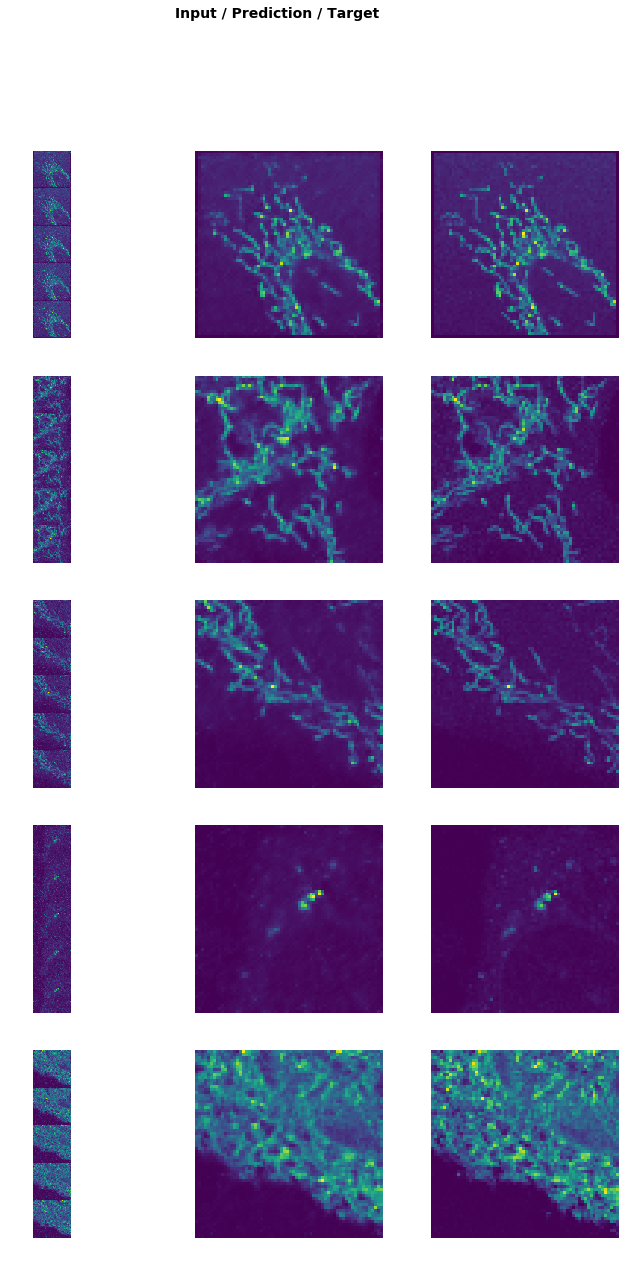

In [38]:
learn.load('multiimg.1').to_fp32().show_results()

In [40]:
bs = 4
size = 128
data = get_data(bs, size, scale=1, max_zoom=1.2)
learn = Learner(data, model, metrics=superres_metrics, loss_func=loss) #, opt_func=opt_func)
learn = learn.load('multiimg.1').to_fp16(loss_scale=64)
gc.collect()

0

In [41]:
learn.fit_one_cycle(cyc_len=3, max_lr=1e-3)
learn.save('multiimg.2')

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.001022,0.000936,0.000936,0.856710,30.895966,04:47
1,0.000931,0.000938,0.000938,0.864127,30.902773,04:45
2,0.000906,0.000919,0.000919,0.866476,30.998579,04:45


In [16]:
bs = 4
size = 256
data = get_data(bs, size, scale=1, max_zoom=1.2)
learn = Learner(data, model, metrics=superres_metrics, loss_func=loss) #, opt_func=opt_func)
learn = learn.load('multiimg.2').to_fp16(loss_scale=64)
gc.collect()

0

In [17]:
learn.fit_one_cycle(cyc_len=3, max_lr=1e-3)
learn.save('multiimg.3')

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.001313,0.001275,0.001275,0.794326,29.512045,04:29
1,0.001376,0.001284,0.001284,0.791974,29.448706,04:48
2,0.001257,0.001248,0.001248,0.791739,29.598085,04:48


In [18]:
learn.fit_one_cycle(cyc_len=3, max_lr=1e-4)
learn.save('multiimg.4')

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.001292,0.001248,0.001248,0.793997,29.601837,04:49
1,0.001302,0.001249,0.001249,0.789645,29.593628,04:46
2,0.001166,0.001248,0.001248,0.794560,29.600636,04:46


In [10]:
bs = 4
size = 512
data = get_data(bs, size, scale=1, max_zoom=1.2)
learn = Learner(data, model, metrics=superres_metrics, loss_func=loss) #, opt_func=opt_func)
learn = learn.load('multiimg.4').to_fp16(loss_scale=64)
gc.collect()

0

In [11]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-5)
learn.save('multiimg.5')


epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.001313,0.001446,0.001446,0.744770,28.900372,06:47


In [12]:
learn.save('multiimg_best')

In [13]:
learn = Learner(data, model, 
                metrics=superres_metrics, 
                loss_func=loss,
                callbacks=[SaveModelCallback(learn, name='multiimg_best')]
               ) #, opt_func=opt_func)
learn = learn.load('multiimg_best').to_fp16(loss_scale=64)

learn.fit_one_cycle(cyc_len=50, max_lr=5e-6)
learn.save('multiimg.6')

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.001354,0.001446,0.001446,0.744438,28.901110,06:48
1,0.001431,0.001445,0.001445,0.744762,28.902103,06:38
2,0.001407,0.001445,0.001445,0.745935,28.900921,06:40
3,0.001308,0.001444,0.001444,0.746072,28.903830,06:43
4,0.001421,0.001445,0.001445,0.746917,28.900568,06:43
5,0.001518,0.001443,0.001443,0.747067,28.904356,06:42
6,0.001476,0.001442,0.001442,0.747098,28.909405,06:43
7,0.001400,0.001441,0.001441,0.746679,28.912645,07:41


Better model found at epoch 0 with val_loss value: 0.0014456958742812276.
Better model found at epoch 1 with val_loss value: 0.0014452001778408885.
Better model found at epoch 3 with val_loss value: 0.001444085966795683.
Better model found at epoch 5 with val_loss value: 0.0014432272873818874.
Better model found at epoch 6 with val_loss value: 0.0014417312340810895.
Better model found at epoch 7 with val_loss value: 0.0014407256385311484.


KeyboardInterrupt: 

In [ ]:
#learn.show_results(rows=3)

In [ ]:
x,y = data.one_batch()
x.shape, y.shape

In [ ]:
bs = 4
size = 256
data = get_data(bs, size, scale=4, max_zoom=1.2)
in_c = 5
out_c = 1
nf = gcval = 16 # 32
nb = 5 # 23

model = TwoXModel(RRDB_Net(in_c, out_c, nf, nb, gc=gcval))
model = RRDB_Net(in_c, out_c, nf, nb, gc=gcval)
model = nn.DataParallel(model)
learn = Learner(data, model, loss_func=loss) #, opt_func=opt_func)
learn = learn.to_fp16()
learn = learn.load('multiimg.1')

In [ ]:
learn.fit_one_cycle(2, max_lr=1e-3)

In [ ]:
learn.save('multiimg.2')

In [ ]:
learn.show_results(rows=3, imgsize=5)

In [12]:
movie_files = []
movie_files = list(Path('/scratch/bpho/datasets/movies_001/test').glob('*05*.czi'))
#movie_files += list(Path('/scratch/bpho/datasources/low_res_test/').glob('low res confocal*.czi'))
#movie_files += list(Path('/scratch/bpho/datasources/neuron_movies2/').glob('low*.*'))
#movie_files += list(Path('/DATA/WAMRI/salk/uri/bpho/datasources/neuron_movies/').glob('low res 300 time points 2*.czi'))
#movie_files += list(Path('/DATA/WAMRI/salk/uri/bpho/datasources/neuron_movies/').glob('*time points 2*.tif'))
movie_files = list(Path('/DATA/donow/').glob('*.czi'))

In [13]:
movie_files

[PosixPath('/DATA/donow/low res confocal 2 redo the 2nd time.czi'),
 PosixPath('/DATA/donow/low res confocal 1.czi'),
 PosixPath('/DATA/donow/low res confocal 2 redo again the 4th time.czi'),
 PosixPath('/DATA/donow/low res confocal 2.czi'),
 PosixPath('/DATA/donow/low res confocal 2 redo again.czi'),
 PosixPath('/DATA/donow/low res confocal 2 redo again the 3rd time.czi'),
 PosixPath('/DATA/donow/low res confocal 2 redo.czi'),
 PosixPath('/DATA/donow/low res confocal 2 redo again the 5th time.czi')]

In [14]:
from scipy.ndimage.interpolation import zoom as npzoom

def unet_image_from_tiles(learn, in_img, tile_sz=128, scale=4, wsize=3):
    cur_size = in_img.shape[1:3]
    c = in_img.shape[0]
    new_size = (cur_size[0]*scale, cur_size[1]*scale)
    w, h = cur_size
    
    in_tile = torch.zeros((c,tile_sz//scale,tile_sz//scale))
    out_img = torch.zeros((1,w*scale,h*scale))
    tile_sz //= scale
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = tensor(in_img[:,x_start:x_end, y_start:y_end])
            
            img_list = [Image(tensor(npzoom(in_tile[i], scale, order=1))[None]) for i in range(wsize)]
            #img_list += img_list
            
            tlist = MultiImage(img_list)
            out_tile,_,_ = learn.predict(tlist)
            
            out_x_start = x_start * scale
            out_x_end = x_end * scale
            out_y_start = y_start * scale
            out_y_end = y_end * scale

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = (x_end-x_start) * scale
            in_y_end = (y_end-y_start) * scale
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img

In [15]:
from skimage.io import imsave

def tif_predict_movie(learn, tif_in, orig_out='orig.tif', pred_out='pred.tif', size=128, wsize=3):
    im = PIL.Image.open(tif_in)
    im.load()
    times = im.n_frames
    #times = min(times,100)
    imgs = []
    for i in range(times):
        im.seek(i)
        imgs.append(np.array(im).astype(np.float32)/255.)
    img_data = np.stack(imgs)
    
    def pull_frame(i):
        im.seek(i)
        im.load()
        return np.array(im)
        
    preds = []
    origs = []
    img_max = img_data.max()
    print(img_max)
    print('max: ', img_max)
    for t in progress_bar(list(range(0,times-wsize+1))):
        img = img_data[t:(t+wsize)].copy()
        img /= img_max
        
        out_img = unet_image_from_tiles(learn, img, tile_sz=size, wsize=wsize)
        pred = (out_img*255).cpu().numpy().astype(np.uint8)
        preds.append(pred)
        orig = (img[1][None]*255).astype(np.uint8)
        origs.append(orig)

    all_y = np.concatenate(preds)
    #print(all_y.shape)
    imageio.mimwrite(pred_out, all_y, bigtiff=True) #, fps=30, macro_block_size=None) # for mp4
    all_y = np.concatenate(origs)
    #print(all_y.shape)
    imageio.mimwrite(orig_out, all_y, bigtiff=True) #, fps=30, macro_block_size=None)


def czi_predict_movie(learn, czi_in, orig_out='orig.tif', pred_out='pred.tif', size=128, wsize=3):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        #times = min(times, 100)
        x,y = proc_shape['X'], proc_shape['Y']
        print(f'czi: x:{x} y:{y} t:{times} z:{depths}')
        
        #folder_name = Path(pred_out).stem
        #folder = Path(folder_name)
        #if folder.exists(): shutil.rmtree(folder)
        #folder.mkdir()
        
        data = czi_f.asarray().astype(np.float32)/255.
        preds = []
        origs = []
        
        img_max = data.max()
        print(img_max)
        for t in progress_bar(list(range(0,times-wsize+1))):
            idx = build_index(proc_axes, {'T': slice(t,t+wsize), 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].copy()
            img /= img_max
            
            out_img = unet_image_from_tiles(learn, img, tile_sz=size, wsize=wsize)
            pred = (out_img*255).cpu().numpy().astype(np.uint8)
            preds.append(pred)
            #imsave(folder/f'{t}.tif', pred[0])
            
            orig = (img[1][None]*255).astype(np.uint8)
            origs.append(orig)
            
        all_y = np.concatenate(preds)
        #print(all_y.shape)
        imageio.mimwrite(pred_out, all_y, bigtiff=True) #, fps=30, macro_block_size=None) # for mp4
        all_y = np.concatenate(origs)
        #print(all_y.shape)
        imageio.mimwrite(orig_out, all_y, bigtiff=True) #, fps=30, macro_block_size=None)
        

/home/fredmonroe/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [19]:
bs = 1
size = 4*440
data = get_data(bs, size, scale=1, max_zoom=1.2)

in_c = 5
out_c = 1

#loss = TwoYLoss(F.mse_loss)
loss = F.mse_loss

#model = TwoXModel(RRDB_Net(in_c, out_c, nf, nb, gc=gcval))



#model = RRDB_Net(in_c, out_c, nf, nb, gc=gcval)

body = nn.Sequential(*list(xresnet34(c_in=in_c).children())[:-2])
model = DynamicUnet(
    body, n_classes=out_c,
    blur=True, blur_final=True,
    self_attention=True, norm_type=NormType.Weight, 
    last_cross=True, bottle=True
)


learn = Learner(data, model, callback_fns=LossMetrics, loss_func=loss) #, opt_func=opt_func)
learn = learn.to_fp16()
learn = learn.load('multiimg_best')

gc.collect()

0

In [20]:
x,y = data.one_batch()
print(x.shape, y.shape)

torch.Size([1, 5, 1760, 1760]) torch.Size([1, 1, 1760, 1760])


In [ ]:
for fn in progress_bar(movie_files):
    #try:
        pred_name = f'{fn.stem}_pred.tif'
        orig_name = f'{fn.stem}_orig.tif'
        if not Path(pred_name).exists():
            if fn.suffix == '.czi':
                print(f'czi {fn.stem}')
                czi_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name, wsize=5)
            elif fn.suffix == '.tif':
                tif_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name, wsize=5)
                tif_fn = fn
                print(f'tif {fn.stem}')
        else:
            print(f'skip: {fn.stem}')
    #except:
    #    print(f'err: {fn.stem}')

czi low res confocal 2 redo the 2nd time
czi: x:440 y:440 t:1600 z:1
0.34509805


czi low res confocal 1
czi: x:440 y:440 t:730 z:1
1.0


czi low res confocal 2 redo again the 4th time
czi: x:440 y:440 t:1600 z:1
0.20392157


In [18]:
4*380

1520

In [ ]:
1600